<a href="https://colab.research.google.com/github/Praneet9/Pytorch-Learning/blob/master/CNN_Mnist_Torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_dataloader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

In [0]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

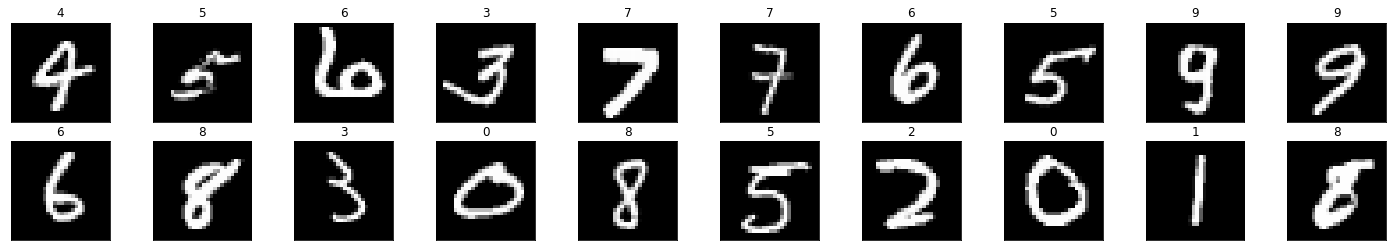

In [0]:
dataiter = iter(training_dataloader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in range(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks = [], yticks = [])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(labels[idx].item())

In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 20, 5, 1)
    self.conv2 = nn.Conv2d(20, 50, 5, 1)

    self.fc1 = nn.Linear(4*4*50, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*50)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)

    return x

In [0]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [0]:
epochs = 12
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  for inputs, labels in training_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)

    running_corrects += torch.sum(preds == labels.data).item()
    running_loss += loss.item()
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_dataloader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)

        val_running_corrects += torch.sum(val_preds == val_labels.data).item()
        val_running_loss += val_loss.item()


    epoch_loss = running_loss / len(training_dataloader)
    epoch_acc = running_corrects / len(training_dataloader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss / len(validation_dataloader)
    val_epoch_acc = val_running_corrects / len(validation_dataloader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print(f'Epoch:{e+1} Training Loss: {round(epoch_loss, 4)} Training Accuracy: {round(epoch_acc, 4)} Validation Loss: {round(val_epoch_loss, 4)} Validation Accuracy: {round(val_epoch_acc, 4)}')

Epoch:1 Training Loss: 0.5862 Training Accuracy: 84.1867 Validation Loss: 0.1859 Validation Accuracy: 94.57
Epoch:2 Training Loss: 0.1553 Training Accuracy: 95.34 Validation Loss: 0.1062 Validation Accuracy: 96.67
Epoch:3 Training Loss: 0.103 Training Accuracy: 96.98 Validation Loss: 0.0766 Validation Accuracy: 97.62
Epoch:4 Training Loss: 0.0788 Training Accuracy: 97.6567 Validation Loss: 0.0627 Validation Accuracy: 97.97
Epoch:5 Training Loss: 0.0654 Training Accuracy: 98.045 Validation Loss: 0.0514 Validation Accuracy: 98.32
Epoch:6 Training Loss: 0.0558 Training Accuracy: 98.2433 Validation Loss: 0.0451 Validation Accuracy: 98.64
Epoch:7 Training Loss: 0.0488 Training Accuracy: 98.52 Validation Loss: 0.0432 Validation Accuracy: 98.55
Epoch:8 Training Loss: 0.0434 Training Accuracy: 98.705 Validation Loss: 0.0396 Validation Accuracy: 98.79
Epoch:9 Training Loss: 0.0386 Training Accuracy: 98.8283 Validation Loss: 0.0392 Validation Accuracy: 98.67
Epoch:10 Training Loss: 0.0354 Traini

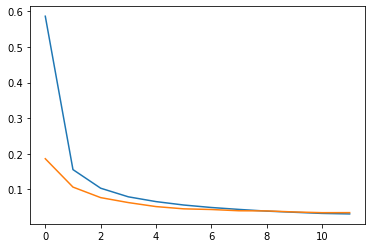

In [0]:
plt.plot(running_loss_history, label='Training Loss')
plt.plot(val_running_loss_history, label='Validation Loss')
plt.show()

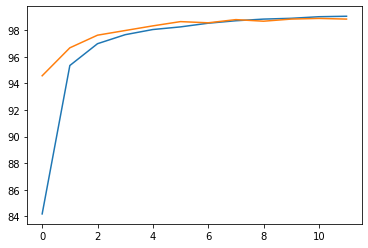

In [0]:
plt.plot(running_corrects_history, label='Training Accuracy')
plt.plot(val_running_corrects_history, label='Validation Accuracy')
plt.show()